# Table of contents
* [Preparing the data and plots](#preparing)
* [Psychometric function](#psychometrics)
* [Probability of CoM trials](#p_com)
* [Probability of CoM trials depending on initation times](#p_com_IT)
* [Probability of CoM trials (obsolete)](#p_com_obsolete)

<a name="preparing"></a>
# Preparing data and plots
First, we import the basic modules and read the data (assuming it's already pre-processed). Change the path to the files if necessary 

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import data_reader

with open('figure_path.txt') as f:
    figure_path = f.read()

with open('data_path.txt') as f:
    data_path = f.read()

dr = data_reader.DataReader()
choices, dynamics = dr.get_data(path=os.path.join(data_path, 'processed'), rename_vars=True)

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

# color palette for participant IDs
palette_subj = 'magma_r'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="psychometrics"></a>
# Psychometric function (CoM vs non-CoM)

Plot individual psychometric functions separately for CoM and non-CoM trials

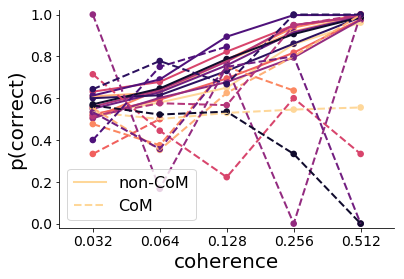

In [22]:
def plot_psychometric_function_individual(c, color, marker='o'):
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN 
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], markers=[marker, marker], 
                       scale=0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['non-CoM','CoM'])
    
    return ax

def plot_psychometric_functions(choices):
    plt.figure()
    choices = choices[~(choices.coherence==0)]
    subjects = np.sort(choices.index.get_level_values('subj_id').unique().values)
    colors = sns.color_palette(palette_subj, len(subjects))
    for i, subj_id in enumerate(subjects):
        ax = plot_psychometric_function_individual(choices.loc[subj_id], color=colors[i])
    ax.set_ylim([-0.02, 1.02])

plot_psychometric_functions(choices)

# Psychometric function (initial vs final)

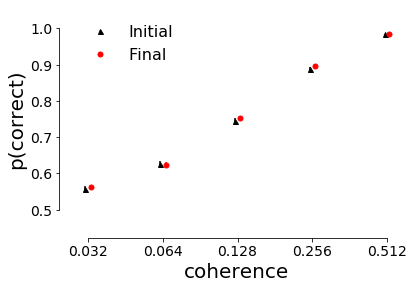

In [24]:
def plot_psychometric_function_aggregate_initial(c, color='k'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    offset = np.logspace(-3, -2, 5)
    
    psf_init = c.groupby('coherence').apply(lambda c: len(c[c.is_correct_init])/len(c)).rename('p_correct').reset_index()
    ax.plot(psf_init.coherence-offset, psf_init.p_correct, color=color, ls='', marker='^', label='Initial', ms=5)
    
    psf_final = c.groupby('coherence').apply(lambda c: len(c[c.is_correct])/len(c)).rename('p_correct').reset_index()
    ax.plot(psf_final.coherence+offset, psf_final.p_correct, color='red', ls='', marker='o', label='Final', ms=5)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')    
    ax.set_xscale('log')
    
    ax.set_xticks(np.sort(choices.coherence.unique()))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_locator(mpl.ticker.NullLocator())
    ax.legend(frameon=False)
    
    return ax

def get_ci_initial(c, correct_col):
    psf = np.array([len(c[(c[correct_col]) & (c.coherence==coherence)])/len(c[(c.coherence==coherence)]) 
                    for coherence in np.sort(c.coherence.unique())])       
    ci = pd.DataFrame(psf, index=np.sort(c.coherence.unique()), columns=['p_correct'])
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

def plot_psychometric_function_ci_initial(choices):
    offset = np.logspace(-3, -2, 5)
    
    choices = choices[~(choices.coherence==0)]
    
    ax = plot_psychometric_function_aggregate_initial(choices)
    ci = get_ci_initial(choices, 'is_correct_init')
    ax.vlines(x=np.sort(choices.coherence.unique())-offset, ymin=ci.ci_l, ymax=ci.ci_r, color='k', zorder=10)
    
    ci = get_ci_initial(choices, 'is_correct')
    ax.vlines(x=np.sort(choices.coherence.unique())+offset, ymin=ci.ci_l, ymax=ci.ci_r, color='r', zorder=10)
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.5, 1.0, 6)))

    ax.set_ylim(0.45, 1.05)
    sns.despine(ax=ax, trim=True, offset=10)
    
plot_psychometric_function_ci_initial(choices)

<a name="p_com"></a>
# Probability of CoM

First, let's take a look at number of correct/error CoM at each coherence level

                      n_com
coherence is_correct       
0.032     False          80
          True           95
0.064     False          92
          True           80
0.128     False          61
          True           94
0.256     False          23
          True           56
0.512     False          10
          True           14
Total CoM: 0.028


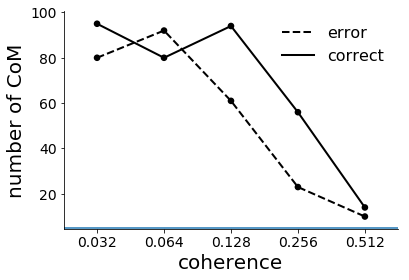

In [26]:
def plot_n_com_by_is_correct(c, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    n_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)])
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c.is_correct.unique())]
    
    n_com = pd.DataFrame(n_com, columns=['n_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', 'is_correct']))
    ax = sns.pointplot(data=n_com.reset_index(), x='coherence', y='n_com', hue='is_correct',
                       palette=[color, color], linestyles=['--', '-'], scale = 0.75)
    
    print(n_com)
    print('Total CoM: %.3f' % (len(c[c.is_com])/len(c)))
    ax.axhline(5)
    ax.set_xlabel('coherence')
    ax.set_ylabel('number of CoM')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['error','correct'], frameon=False)
    return ax

plot_n_com_by_is_correct(choices)

<a name="p_com_IT"></a>
# Probability of CoM trials depending on initiation times

Let's look at probability of CoM for trials with different initation times

In [29]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    # use this line when probability is to be calculated conditional on the IT tertile level
    p_com = (choices.groupby(by=['coherence', var])
             .apply(lambda c: len(c[c.is_com])/len(c) if len(c) else np.NaN)
             .rename('p_com'))
    # use this one when probability is to be calculated within coherence level across all IT tertiles
#     p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(choices, var, palette='viridis_r', n_threshold=10):
    plt.figure()

    ci = get_ci_vs_var(choices, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette=palette)
    ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)

    ax.set_ylim(-0.005, 0.12)
    ax.set_ylabel('p(CoM)')
    sns.despine(ax=ax, trim=True, offset=5)
    legend = ax.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
    legend.set_title(var, prop = {'size':'xx-large'})
    return ax

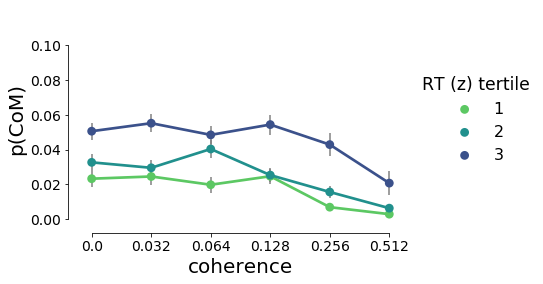

In [31]:
plot_p_com_vs_var_ci(choices, 'RT (z) tertile', n_threshold=0)

We can further split this into correct/error trials to obtain plots similar to SI Fig 3 in Resulaj et al (2009), but then we have too much noise, especially at high coherences

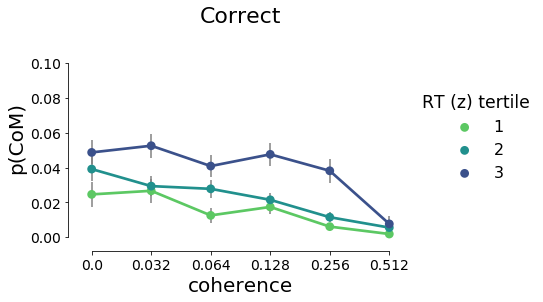

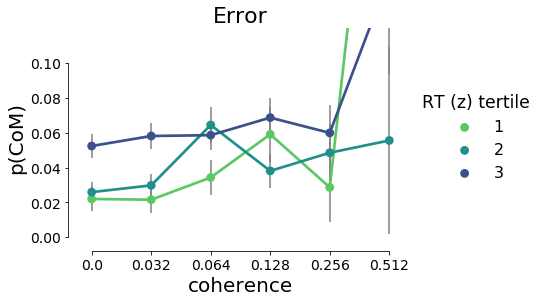

In [35]:
def plot_p_com_vs_coherence_by_var_by_is_correct(choices):
    ax = plot_p_com_vs_var_ci(choices[(choices.is_correct)], 'RT (z) tertile')
    ax.set_title('Correct')
    ax = plot_p_com_vs_var_ci(choices[(~choices.is_correct)], 'RT (z) tertile')
    ax.set_title('Error')
#     ax.set_ylim(-0.01, 0.5)

plot_p_com_vs_coherence_by_var_by_is_correct(choices)

<a name="p_com_obsolete"></a>
# Number and probability of CoM per participant

Total number of CoMs

In [4]:
len(choices[choices.is_com])

775

Rate of CoMs per subject

In [6]:
com_rate = [100*len(choices[choices.is_com].loc[subj_id])/len(choices.loc[subj_id]) 
            for subj_id 
            in choices.index.get_level_values('subj_id').unique().values]
print('Mean rate of CoM %.1f%%' % np.mean(com_rate))
print('Median rate of CoM %.1f%%' % np.median(com_rate))
print('Range of CoM rates: %.1f%% to %.1f%%' % (np.min(com_rate), np.max(com_rate)))
# print(com_rate, '%.1f%%' % )

Mean rate of CoM 3.0%
Median rate of CoM 2.4%
Range of CoM rates: 0.3% to 6.1%


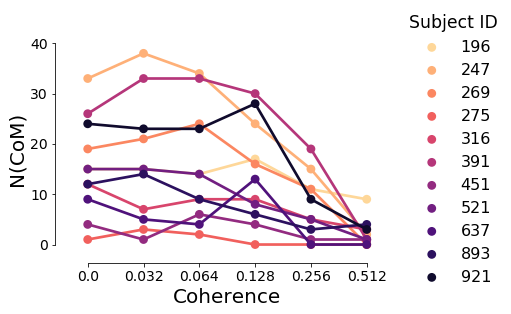

In [36]:
def plot_count_vs_coherence(count):
    ax = sns.pointplot(data=count.reset_index(), x='coherence', y='count', hue='subj_id', 
                       ci=None, scale=1, palette=palette_subj, legend=False)
    legend = ax.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
    legend.set_title('Subject ID', prop = {'size':'xx-large'})
    ax.set_xlabel('Coherence')    
    sns.despine(ax=ax, trim=True, offset=5)
    return ax

com_count = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])).rename('count')
ax = plot_count_vs_coherence(com_count)
ax.set_ylabel('N(CoM)');

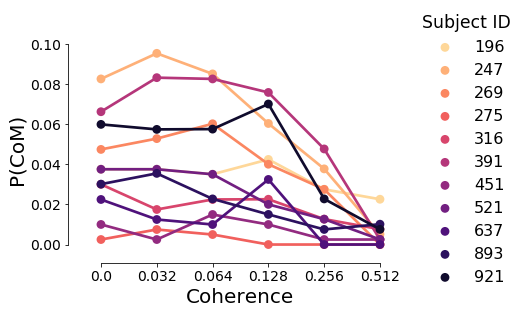

In [37]:
p_com = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])/len(c)).rename('count')
ax = plot_count_vs_coherence(p_com)
ax.set_ylabel('P(CoM)');